## Hand Gesture Classification by SVM 

Dataset is of sign language containing 10 classes, each having 3000 images. All the images are in RGB format. You need to perform the following steps.
1. Convert the image into binary image. From each class in the dataset use 70% for training and 30% for testing.
2. Extract features from these and store them in a csv file.(features should be chosen by you)
3. Use the features for classification using SVM.
4. Print classification report.
5. Apply grid search for hyper-parameter tuning.(eg: kernel, C, gamma)
6. Report the model with best accuracy.
 

In [1]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report

from skimage.transform import resize
from skimage import io
import cv2
from skimage.color import rgb2gray
from scipy.ndimage import uniform_filter
from skimage.feature import hog
from skimage import exposure

import seaborn as sns

In [2]:
# Data is stored in a folder named data
PATH = "data/"

In [3]:
%%time
# Reading and storing images as an array in X and its class in y
y = []
X = []
for path, subdirs, files in os.walk(PATH):
    if len(subdirs) == 0:
        for file in files:
            img = io.imread(path + "/" + file)
            X.append(img)
            y.append(path.split("/")[-1])

CPU times: user 1min 14s, sys: 4.34 s, total: 1min 19s
Wall time: 2min 19s


In [4]:
# encoding characters and nothing to numerical values
mp = {
    'nothing': 0,
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
    'H': 8,
    'I': 9
}

In [5]:
# Converting y to numerical values
y = np.array([mp[i] for i in y])

**List of all that things i have tried, but this notebook only contains few things**
* Global thresholding images for converting to binary images:  
  
| Threshold | Accuracy           |
|-----------|--------------------|
| 0.2       | 0.710888888888888  |
| 0.3       | 0.8314444444444444 |
| 0.4       | 0.8855555555555555 |
| 0.45      | 0.8723333333333333 |
| 0.5       | 0.8675555555555555 |
| 0.55      | 0.8644444444444445 |
| 0.6       | 0.8548888888888889 |
| 0.65      | 0.8063333333333333 |
| 0.7       | 0.6822222222222222 |
| 0.75      | 0.5851111111111111 |
| 0.8       | 0.5263333333333333 |
  
Which gives good accuracy ~ 88.5% when using global threshold 0.4
* Tried grayscale image, which gives ~99.5 accuracy but that is not binary image.
* Also tried thresholding different pixels to convert it into binary image, RGB pixels but accuracy was not that great.
* Tried applying PCA for grayscale images and then applying global thresholding, which didn't improved accuracy.
* Tried image segmentation/boundary detection techniques like gaussian thresholding, adaptive mean thresholding, canny edge detection but none of those works too well!
* 


## HOG image features works well

In [6]:
def hog_conversion(img):
    '''
    img: np array, an image object
    returns: binary image
    '''
    H, hogImage = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")

    return hogImage

In [7]:
%%time
# converting images to hog_image
X_hog = np.array([hog_conversion(i) for i in X])

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


CPU times: user 17min 54s, sys: 39.5 s, total: 18min 34s
Wall time: 18min 32s


In [8]:
# flattening the image
X_hog = X_hog.reshape(30000, -1)

### Saving data in a csv file

Not reading from csv file as it stores everything as float64 datatype and will take too much ram and kernel will panick

In [12]:
# Saving numpy array as a csv file
np.savetxt("data.csv", X_hog, delimiter=',')
# Reading that saved file and adding corresponding values to it
df = pd.read_csv("data.csv", header=None)
df["y"] = y
df.to_csv("final_data.csv")

In [ ]:
# df = pd.read_csv("final_data.csv")
# df = df.astype('float16')
# X_hog = df.drop(["y", "Unnamed: 0"], axis=1)
# y = df.y

### Using linearSVC classifier from sklearn library

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.30, random_state=42)

In [10]:
%%time
clf = LinearSVC(random_state=0, tol=1e-5, max_iter=5000)
clf.fit(X_train, y_train)  

CPU times: user 31min 42s, sys: 4.19 s, total: 31min 47s
Wall time: 32min 35s


/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=5000,
          multi_class='ovr', penalty='l2', random_state=0, tol=1e-05,
          verbose=0)

In [11]:
%%time
clf.score(X_test, y_test)

CPU times: user 1.77 s, sys: 299 ms, total: 2.06 s
Wall time: 809 ms


0.976

### Using SVC classifier from sklearn

In [9]:
# A simple function that will return model and accuracy
def auto_svc_train(X, y):
    X = np.array(X).reshape(30000, -1)
    svc = SVC(random_state=0, C=0.001, kernel='linear')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    svc.fit(X_train, y_train)
    return svc, svc.score(X_test, y_test)

In [13]:
%%time
model, accuracy = auto_svc_train(X_hog, y)
print(f"Accuracy is {accuracy}")

Accuracy is 0.9958888888888889
CPU times: user 1h 12min 8s, sys: 3.42 s, total: 1h 12min 11s
Wall time: 1h 12min 4s


In [14]:
%%time
model = SVC(random_state=0, C=0.001, kernel='linear')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

CPU times: user 1h 12min 4s, sys: 3.62 s, total: 1h 12min 8s
Wall time: 1h 12min 3s


### Classification report

In [16]:
# classification report
report = classification_report(y_test, y_pred)
print("Classification report: ")
print(report)

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       886
           1       0.99      1.00      0.99       881
           2       1.00      0.99      0.99       942
           3       1.00      1.00      1.00       921
           4       1.00      1.00      1.00       881
           5       0.99      0.99      0.99       872
           6       1.00      0.99      1.00       913
           7       1.00      0.99      1.00       869
           8       0.99      1.00      1.00       939
           9       1.00      1.00      1.00       896

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000



## Hyperparameter tuning using grid search

In [17]:
# Hyperparameter tuning on subset of training data
X_train = X_train[:10000]
y_train = y_train[:10000]

# Tuning the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                     'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
                   ]

scores = ['accuracy']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5,
                       scoring=score, n_jobs=-1)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
print("DONE")


# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 0.001, 'kernel': 'linear'}

Grid scores on development set:

0.103 (+/-0.000) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.103 (+/-0.000) for {'C': 10, 'gamma': 0.01, 'kernel': '

## Final Model

Above classification report is same for final model

In [1]:
svc = SVC(random_state=0, C=0.001, kernel='linear')
svc.fit(X_train, y_train)
acc = svc.score(X_test, y_test)
print(f"Accuracy is {acc}")

Accuracy is 0.9958888888888889


**Final accuracy is 99.5888889%**

In [18]:
# classification report
report = classification_report(y_test, y_pred)
print("Classification report: ")
print(report)

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       886
           1       0.99      1.00      0.99       881
           2       1.00      0.99      0.99       942
           3       1.00      1.00      1.00       921
           4       1.00      1.00      1.00       881
           5       0.99      0.99      0.99       872
           6       1.00      0.99      1.00       913
           7       1.00      0.99      1.00       869
           8       0.99      1.00      1.00       939
           9       1.00      1.00      1.00       896

    accuracy                           1.00      9000
   macro avg       1.00      1.00      1.00      9000
weighted avg       1.00      1.00      1.00      9000



## Other things which didn't worked quite well

In [ ]:
def plot_5_from_each_class(X, y):
    fig, ax = plt.subplots(nrows=10, ncols=5, figsize=(80, 180))

    plot_index = 0
    for i in np.unique(y):
        indices = np.where(y == i)[0]
        for j in range(5):
            ax[i][j].imshow(X[indices[j]])
            ax[i][j].title.set_text(i)
    plt.plot()
    plt.show()


In [ ]:
plot_5_from_each_class(X, y)

In [ ]:
# converting 50*50*3 to 50*50 using skimage color library
X_gray = np.array([color.rgb2gray(i) for i in X])
# X_gray = np.array([color.rgb2gray(i) for i in X])

In [ ]:
# X_red = X[:,:, :, 0]
X_red = X[:, :, :, 0]

In [ ]:
# X_green = X[:,:, :, 1]
X_green = X[:, :, :, 1]

In [ ]:
X_blue = X[:, :, :, 2]

In [ ]:
# Adaptive thresholding, using thresh binary, and thresh otsu
X_binary = []
for i in X:
    img = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    (thresh, im_bw) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    im_bw = cv2.threshold(img, thresh, 255, cv2.THRESH_BINARY)[1]
    X_binary.append(im_bw)
X_binary = np.array(X_binary)


In [ ]:
X_mean_threshold = []
# temp = X_small.astype('float32')
for i in X:
    img = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    im_bw = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
    X_mean_threshold.append(im_bw)
X_mean_threshold = np.array(X_mean_threshold)


In [ ]:
X_gaussian_threshold = []
for i in X:
    img = cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
    im_bw = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
    X_gaussian_threshold.append(im_bw)
X_gaussian_threshold = np.array(X_gaussian_threshold)


In [ ]:
def pca_vis(data, n_comp):
    temp = np.array(data).flatten().reshape(30000, -1)
    pca = PCA(n_components=n_comp, random_state=0)
    pca.fit(temp)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show()
    return pca.transform(temp)
    

In [ ]:
%%time
X_PCA = pca_vis(X, 150)

In [ ]:
def auto_svc_train(X, y):
    X = np.array(X).reshape(30000, -1)
    svc = SVC(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    svc.fit(X_train, y_train)
    return svc.score(X_test, y_test)

In [42]:
auto_svc_train(X_PCA, y)

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.09655555555555556

In [46]:
X_gray = np.array([color.rgb2gray(i) for i in X])

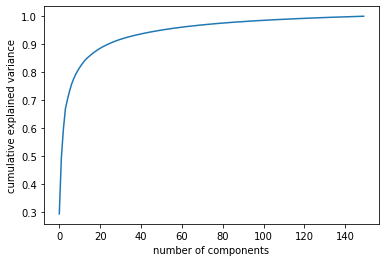

In [47]:
X_gray_PCA = pca_vis(X_gray_PCA, 150)

In [48]:
auto_svc_train(X_gray_PCA, y)

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9951111111111111

In [ ]:
%%time
def transform_image(filename):
    im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    im_bw = cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)[1]
    return im_bw

# storing data into arrays
X_transformed = []
for folder in subfolders:
    folder_name = folder.split("/")[1]
    images = [f.name for f in os.scandir(folder) if f.is_file()]
    for i in images:
        filename = PATH + folder_name + "/" + i
        img = transform_image(filename)
        X_transformed.append(img)

In [79]:
auto_svc_train(X_transformed, y)

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.09655555555555556

In [ ]:
X_transformed = np.array(X_transformed)

In [ ]:
X_transformed_PCA = pca_vis(X_transformed, 150)

In [ ]:
%%time
X_transformed_PCA = pca_vis(X_transformed, 250)

In [ ]:
plt.imshow(X_transformed[85])

In [8]:
%%time
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure


# image = io.imread("data/B/B45.jpg")
def hog_feature(image):
    fd, hog_image = hog(image, orientations=10, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

#     ax1.axis('off')
#     ax1.imshow(image, cmap=plt.cm.gray)
#     ax1.set_title('Input image')
    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

#     ax2.axis('off')
#     ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
#     ax2.set_title('Histogram of Oriented Gradients')
#     plt.show()
    return hog_image_rescaled

def hog_feature_l2(image):
    fd, hog_image = hog(image, orientations=10, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, multichannel=True, block_norm= 'L2')

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

#     ax1.axis('off')
#     ax1.imshow(image, cmap=plt.cm.gray)
#     ax1.set_title('Input image')
    # Rescale histogram for better display
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

#     ax2.axis('off')
#     ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
#     ax2.set_title('Histogram of Oriented Gradients')
#     plt.show()
    return hog_image_rescaled

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 22.2 µs


In [93]:
image.shape

(512, 512, 3)

In [7]:
%%time
y = []
X_hog = []
for path, subdirs, files in os.walk(PATH):
    if len(subdirs) == 0:
        for file in files:
            img = io.imread(path + "/" + file)
            X_hog.append(hog_feature(img))
            y.append(path.split("/")[-1])

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


CPU times: user 26min 39s, sys: 1min 5s, total: 27min 44s
Wall time: 33min 2s


In [9]:
%%time
y_l2 = []
X_hog_l2 = []
for path, subdirs, files in os.walk(PATH):
    if len(subdirs) == 0:
        for file in files:
            img = io.imread(path + "/" + file)
            X_hog_l2.append(hog_feature_l2(img))
            y_l2.append(path.split("/")[-1])

CPU times: user 24min 33s, sys: 56.6 s, total: 25min 30s
Wall time: 28min 28s


In [ ]:
auto_svc_train(X_hog, y)

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
auto_svc_train(X_hog_l2, y_l2)

In [ ]:
x = 1

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
def auto_svc_train_onevrest(X, y):
    X = np.array(X).reshape(30000, -1)
    svc = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='auto', random_state=0), n_jobs=-1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    svc.fit(X_train, y_train)
    return svc.score(X_test, y_test)

In [ ]:
auto_svc_train_onevrest(X_transformed_PCA, y)

In [7]:
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

NameError: name 'gray' is not defined

In [61]:
import cv2
import numpy as np

def sift_keypoints(img):
    # img = cv2.imread('data/A/A1.jpg')
    gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # sift = cv2.SIFT()
    sift = cv2.xfeatures2d.SIFT_create()
    kp = sift.detect(gray,None)

#     return cv2.drawKeypoints(gray,kp, img)
    return kp
    

In [64]:
zz = sift_keypoints(cv2.imread('data/A/A2.jpg'))

In [65]:
zz[0].pt

(45.69384002685547, 129.53981018066406)

In [66]:
kp[0].pt

(45.52223205566406, 5.032369613647461)

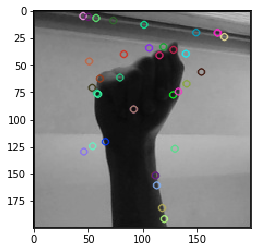

In [40]:
temp = np.zeros((50, 50))
img = cv2.imread('data/A/A1.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.drawKeypoints(gray,kp, temp))

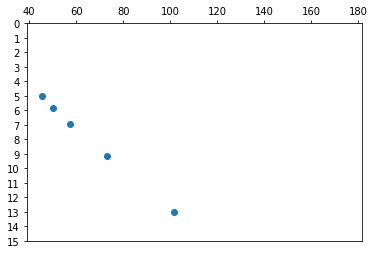

In [70]:
ax=plt.gca()                            # get the axis
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.xaxis.tick_top()                     # and move the X-Axis      
ax.yaxis.set_ticks(np.arange(0, 16, 1)) # set y-ticks
ax.yaxis.tick_left()                    # remove right y-Ticks

ax.scatter(x_, y_)

In [48]:
pts =np.array([kp[idx].pt for idx in range(0, len(kp))])

In [52]:
x_ = pts[:, 0]
y_ = pts[:, 1]

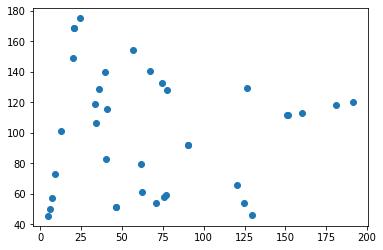

In [71]:
plt.scatter(y_, x_)

In [57]:
??cv2.xfeatures2d.SIFT_create

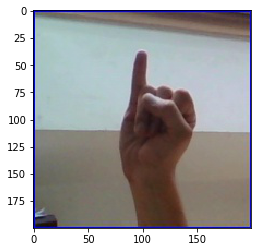

In [21]:
plt.imshow(X[0])

In [8]:
X_small = np.array([cv2.resize(img, (0, 0), fx=0.5, fy=0.5) for img in X])

In [9]:
X_small.shape

(30000, 100, 100, 3)

In [20]:
#!/usr/bin/python
# -*- coding: utf-8 -*-


def hog_feature(im):
    """Compute Histogram of Gradient (HOG) feature for an image
  
       Modified from skimage.feature.hog
       http://pydoc.net/Python/scikits-image/0.4.2/skimage.feature.hog
     
     Reference:
       Histograms of Oriented Gradients for Human Detection
       Navneet Dalal and Bill Triggs, CVPR 2005
     
    Parameters:
      im : an input grayscale or rgb image
      
    Returns:
      feat: Histogram of Gradient (HOG) feature
    
  """

  # convert rgb to grayscale if needed

    if im.ndim == 3:
        image = rgb2gray(im)
    else:
        image = np.at_least_2d(im)

    (sx, sy) = image.shape  # image size
    orientations = 9  # number of gradient bins
    (cx, cy) = (8, 8)  # pixels per cell

    gx = np.zeros(image.shape)
    gy = np.zeros(image.shape)
    gx[:, :-1] = np.diff(image, n=1, axis=1)  # compute gradient on x-direction
    gy[:-1, :] = np.diff(image, n=1, axis=0)  # compute gradient on y-direction
    grad_mag = np.sqrt(gx ** 2 + gy ** 2)  # gradient magnitude
    grad_ori = np.arctan2(gy, gx + 1e-15) * (180 / np.pi) + 90  # gradient orientation

    n_cellsx = int(np.floor(sx / cx))  # number of cells in x
    n_cellsy = int(np.floor(sy / cy))  # number of cells in y

  # compute orientations integral images

    orientation_histogram = np.zeros((n_cellsx, n_cellsy, orientations))
    for i in range(orientations):

    # create new integral image for this orientation
    # isolate orientations in this range

        temp_ori = np.where(grad_ori < 180 / orientations * (i + 1),
                            grad_ori, 0)
        temp_ori = np.where(grad_ori >= 180 / orientations * i,
                            temp_ori, 0)

    # select magnitudes for those orientations

        cond2 = temp_ori > 0
        temp_mag = np.where(cond2, grad_mag, 0)
        orientation_histogram[:, :, i] = uniform_filter(temp_mag,
                size=(cx, cy))[cx / 2::cx, cy / 2::cy].T

    return orientation_histogram.ravel()




In [21]:
hog_feature(X_small[0])

TypeError: slice indices must be integers or None or have an __index__ method

In [10]:
def hog_conversion(img):
#     (H, hogImage) = hog(img, orientations=9, pixels_per_cell=(8, 8),
#         cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1",
#         visualize=True)
    H, hogImage = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)
    hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255))
    hogImage = hogImage.astype("uint8")

    return hogImage

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


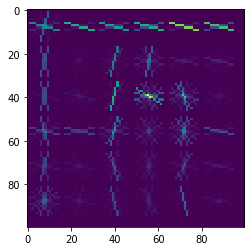

In [11]:
plt.imshow(hog_conversion(X_small[0]))

In [12]:
%%time
X_small_hog = [hog_conversion(img) for img in X_small]

CPU times: user 7min 7s, sys: 3.07 s, total: 7min 10s
Wall time: 7min 18s


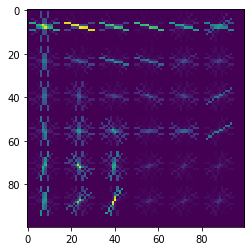

In [16]:
%%time
with Pool(3) as p:
    print(pl.map(auto_svc_train_multi_core_poly, [(X_small_hog_PCA_150, y), (X_small_hog_PCA_120, y), (X_small_hog_PCA_80, y)
                                           , (X_small_hog_PCA_60, y), (X_small_hog_PCA_50, y), (X_small_hog_PCA_40, y)
                                           , (X_small_hog_PCA_38, y)]))

In [13]:
def pca_vis(data, n_comp):
    temp = np.array(data).flatten().reshape(30000, -1)
    pca = PCA(n_components=n_comp, random_state=0)
    pca.fit(temp)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show()
    return pca.transform(temp)

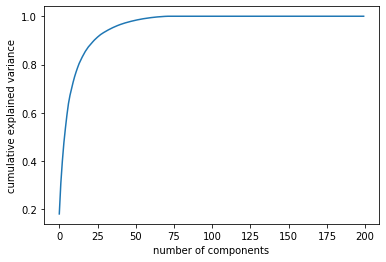

array([[ 3.13039942e+02,  7.09115298e+01, -3.07483150e+02, ...,
         1.99267686e-14,  1.76299947e-14,  3.24393290e-16],
       [-4.44766033e+01,  5.03419314e+02,  3.81278704e+02, ...,
        -2.69207399e-15, -2.34781812e-14,  3.50424984e-15],
       [-9.97776354e+01,  6.62542495e+02,  9.21245312e+01, ...,
        -2.12330153e-15, -3.95516953e-14, -1.57027169e-14],
       ...,
       [-3.76554237e+02, -6.27625777e+01, -5.01300899e+01, ...,
         2.81909912e-14, -9.71445147e-16,  1.84886828e-14],
       [-1.95344683e+02,  3.17290467e+02, -3.33836990e+02, ...,
         5.68295411e-15, -3.60961261e-14, -7.35869699e-15],
       [ 2.79138626e+02,  1.17151093e+02, -3.00265266e+02, ...,
        -4.92806750e-14,  7.87911403e-15, -1.38579469e-14]])

In [13]:
pca_vis(X_small_hog, 200)

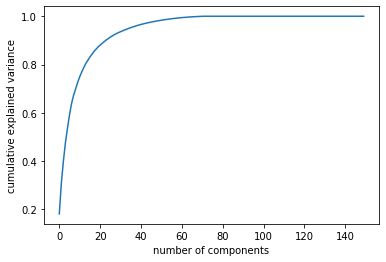

In [14]:
X_small_hog_PCA_150 = pca_vis(X_small_hog, 150)

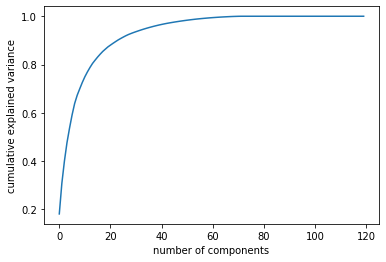

In [15]:
X_small_hog_PCA_120 = pca_vis(X_small_hog, 120)

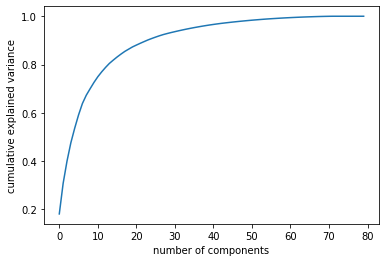

In [16]:
X_small_hog_PCA_80 = pca_vis(X_small_hog, 80)

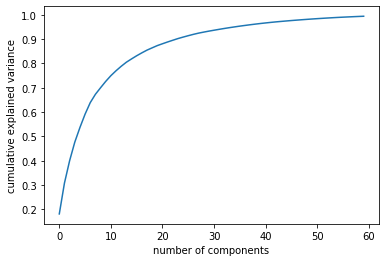

In [17]:
X_small_hog_PCA_60 = pca_vis(X_small_hog, 60)

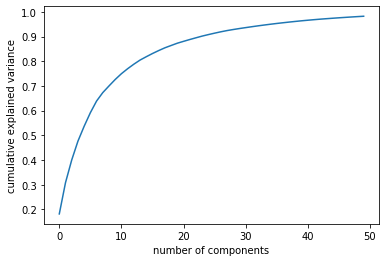

In [18]:
X_small_hog_PCA_50 = pca_vis(X_small_hog, 50)

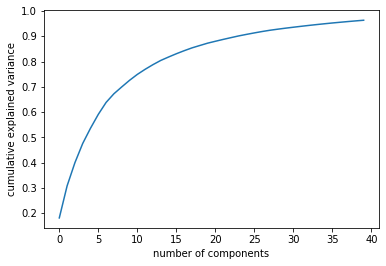

In [19]:
X_small_hog_PCA_40 = pca_vis(X_small_hog, 40)

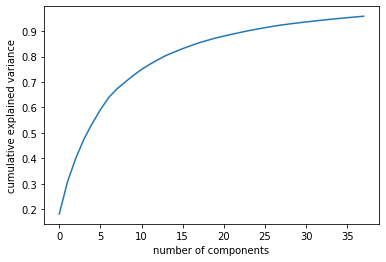

In [20]:
X_small_hog_PCA_38 = pca_vis(X_small_hog, 38)

In [17]:
def auto_svc_train_multi_core(data):
    X, y = data
    X = np.array(X).reshape(30000, -1)
    svc = SVC(kernel='linear', probability=True, random_state=0, gamma='scale')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    svc.fit(X_train, y_train)
    return svc.score(X_test, y_test)

def auto_svc_train_multi_core_rbf(data):
    X, y = data
    X = np.array(X).reshape(30000, -1)
    svc = SVC(kernel='rbf', probability=True, random_state=0, gamma='scale')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    svc.fit(X_train, y_train)
    return svc.score(X_test, y_test)

def auto_svc_train_multi_core_poly(data):
    X, y = data
    X = np.array(X).reshape(30000, -1)
    svc = SVC(kernel='poly', probability=True, random_state=0, gamma='scale')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    svc.fit(X_train, y_train)
    return svc.score(X_test, y_test)



In [26]:
%%time
with Pool(7) as pl:
        print(pl.map(auto_svc_train_multi_core, [(X_small_hog_PCA_150, y), (X_small_hog_PCA_120, y), (X_small_hog_PCA_80, y)
                                           , (X_small_hog_PCA_60, y), (X_small_hog_PCA_50, y), (X_small_hog_PCA_40, y)
                                           , (X_small_hog_PCA_38, y)]))

KeyboardInterrupt: 

In [27]:
%%time
with Pool(7) as pl:
        print(pl.map(auto_svc_train_multi_core_rbf, [(X_small_hog_PCA_150, y), (X_small_hog_PCA_120, y), (X_small_hog_PCA_80, y)
                                           , (X_small_hog_PCA_60, y), (X_small_hog_PCA_50, y), (X_small_hog_PCA_40, y)
                                           , (X_small_hog_PCA_38, y)]))

KeyboardInterrupt: 

In [28]:
%%time
with Pool(7) as pl:
        print(pl.map(auto_svc_train_multi_core_poly, [(X_small_hog_PCA_150, y), (X_small_hog_PCA_120, y), (X_small_hog_PCA_80, y)
                                           , (X_small_hog_PCA_60, y), (X_small_hog_PCA_50, y), (X_small_hog_PCA_40, y)
                                           , (X_small_hog_PCA_38, y)]))

KeyboardInterrupt: 

In [ ]:
%%time
with Pool() as pl:
        print(pl.map(auto_svc_train_multi_core, [(X_small_hog_PCA_150, y), (X_small_hog_PCA_120, y), (X_small_hog_PCA_80, y)
                                           , (X_small_hog_PCA_60, y), (X_small_hog_PCA_50, y), (X_small_hog_PCA_40, y)
                                           , (X_small_hog_PCA_38, y)]))

In [ ]:
# Trying different features from hog
# see https://medium.com/@matlihan/a-trick-to-quickly-explore-hog-features-for-udacity-vehichle-detection-and-tracking-project-0-991-8b6f682a0b01
pixels_per_cell = [(8, 8), (16, 16)]
cells_per_block = [(1, 1), (2, 2), (4, 4)]
orientations = [7, 8, 9, 10]
transform_sqrt = [False, True]
feature_vector = [False, True]
multichannel = [None, True]
kernels = ['linear', 'rbf', 'poly']
probability = [True, False]

for pixels in pixels_per_cell:
    for cells in cells_per_block:
        for orientation in orientations:
            for transform in transform_sqrt:
                for feature in feature_vector:
                    for multi in mutichannel:
                        
                        

In [46]:
from sklearn.multiclass import OneVsRestClassifier
def auto_svc_train_onevrest(X, y):
    X = np.array(X).reshape(30000, -1)
    svc = OneVsRestClassifier(SVC(kernel='linear', probability=True, class_weight='auto', random_state=0), n_jobs=-1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    svc.fit(X_train, y_ train)
    return svc.score(X_test, y_test)

In [48]:
auto_svc_train_onevrest(X_small_hog_PCA, y)

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/backend/semaphore_tracker.py:74: UserWarning: semaphore_tracker: process died unexpectedly, relaunching.  Some semaphores might leak.
  warnings.warn('semaphore_tracker: process died unexpectedly, '


BlockingIOError: [Errno 11] Resource temporarily unavailable

In [8]:
def auto_svc_train(X, y):
    X = np.array(X).reshape(30000, -1)
    svc = SVC(random_state=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    svc.fit(X_train, y_train)
    return svc.score(X_test, y_test)

In [51]:
%%time
auto_svc_train(X_small_hog_PCA, y)

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 3min 35s, sys: 1.36 s, total: 3min 37s
Wall time: 3min 40s


0.09655555555555556

In [52]:
%%time
auto_svc_train(X_small_hog, y)

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 1h 2min, sys: 29.6 s, total: 1h 2min 29s
Wall time: 1h 4min 22s


0.12277777777777778

In [9]:
X_small_gray = rgb2gray(X_small)

In [ ]:
# # temp1 = X_small_gray not copies just stores a reference, use temp1= np.copy(X_small_gray)
# %%time
# temp1 = X_small_gray
# temp1[temp1 < 0.5] = 0
# temp1[temp1 >= 0.5] = 1
# # auto_svc_train(temp1, y)

In [10]:
def gray_thresholding_svm(tpl):
    data, y, thres = tpl
    temp = np.copy(data)
    temp[temp<thres] = 0
    temp[temp>= thres] = 1
    print(f"accuracy is {auto_svc_train(temp, y)}: thres {thres}")
    

In [11]:
from multiprocessing import Pool


In [12]:
%%time
with Pool(13) as pl:
        print(pl.map(gray_thresholding_svm, [(X_small_gray, y, 0.20), (X_small_gray, y, 0.25), (X_small_gray, y, 0.30)
                                           , (X_small_gray, y, 0.35), (X_small_gray, y, 0.40), (X_small_gray, y, 0.45)
                                           , (X_small_gray, y, 0.50), (X_small_gray, y, 0.55), (X_small_gray, y, 0.60)
                                           , (X_small_gray, y, 0.65), (X_small_gray, y, 0.70), (X_small_gray, y, 0.75)
                                           , (X_small_gray, y, 0.80)]))

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/

accuracy is 0.8855555555555555: thres 0.4
accuracy is 0.8723333333333333: thres 0.45
accuracy is 0.8548888888888889: thres 0.6
accuracy is 0.8675555555555555: thres 0.5
accuracy is 0.8636666666666667: thres 0.35
accuracy is 0.8644444444444445: thres 0.55
accuracy is 0.8314444444444444: thres 0.3
accuracy is 0.8063333333333333: thres 0.65
accuracy is 0.7757777777777778: thres 0.25
accuracy is 0.7108888888888889: thres 0.2
accuracy is 0.6822222222222222: thres 0.7
accuracy is 0.5851111111111111: thres 0.75
accuracy is 0.5263333333333333: thres 0.8
[None, None, None, None, None, None, None, None, None, None, None, None, None]
CPU times: user 9.82 s, sys: 12.7 s, total: 22.6 s
Wall time: 52min


In [99]:
auto_svc_train(X_small_gray, y)

/home/bt0/16CS10053/anaconda3/envs/cgcnn/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.7757777777777778

In [102]:
Counter(y)

Counter({'I': 3000,
         'nothing': 3000,
         'C': 3000,
         'F': 3000,
         'B': 3000,
         'D': 3000,
         'G': 3000,
         'A': 3000,
         'H': 3000,
         'E': 3000})

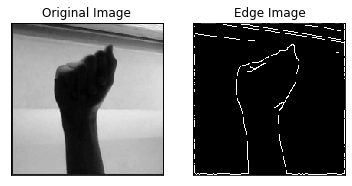

In [14]:
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

In [15]:
im_gray = cv2.imread(f'{PATH}A/A1.jpg', cv2.IMREAD_GRAYSCALE)

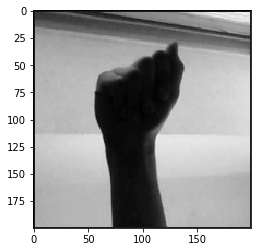

In [17]:
plt.imshow(im_gray, cmap='gray')

## Trying opencv funtion to remove background

In [18]:
def transform_image(filename):
    im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    im_bw = cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)[1]
    z = cv2.imwrite(f'bw_image/{filename}.png', im_bw)
    if z:
        print("Sucessfully saved!")
    else:
        print("Unable to save!")

In [10]:
def show_transform_image(filename):
    im_gray = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    (thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    print(thresh)
    thresh = 130
    im_bw = cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)[1]
    plt.imshow(im_bw)

0.0


TypeError: Image data of dtype object cannot be converted to float

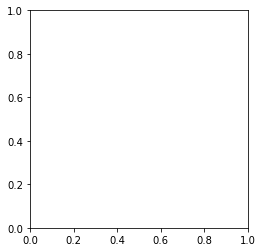

In [11]:
show_transform_image("asl_alphabet_train\\A\\A480.jpg")

In [15]:

(thresh, im_bw) = cv2.threshold(im_gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

In [16]:
# thresh = 110
im_bw = cv2.threshold(im_gray, thresh, 255, cv2.THRESH_BINARY)[1]

In [17]:
cv2.imwrite(f'bw_image{thresh}.png', im_bw)

True

In [11]:
transform_image("asl_alphabet_train\\A\\A1619.jpg")

Sucessfully saved!


In [123]:
for subdir, dirs, files in os.walk(PATH):
    for file in files:
        filepath = subdir + os.sep + file
        filepath = filepath.replace("\\", "\\\\")
        print(filepath)
        transform_image(filepath)

asl_alphabet_train\\A\\A1.jpg
Sucessfully saved!
asl_alphabet_train\\A\\A1.jpg.png
Sucessfully saved!
asl_alphabet_train\\A\\A1.jpg.png.png
Sucessfully saved!
asl_alphabet_train\\A\\A1.jpg.png.png.png
Sucessfully saved!
asl_alphabet_train\\A\\A1.jpg.png.png.png.png
Sucessfully saved!
asl_alphabet_train\\A\\A10.jpg
Sucessfully saved!
asl_alphabet_train\\A\\A10.jpg.png
Sucessfully saved!
asl_alphabet_train\\A\\A10.jpg.png.png
Sucessfully saved!
asl_alphabet_train\\A\\A10.jpg.png.png.png
Sucessfully saved!
asl_alphabet_train\\A\\A10.jpg.png.png.png.png
Sucessfully saved!
asl_alphabet_train\\A\\A100.jpg
Sucessfully saved!
asl_alphabet_train\\A\\A100.jpg.png
Sucessfully saved!
asl_alphabet_train\\A\\A100.jpg.png.png
Sucessfully saved!
asl_alphabet_train\\A\\A100.jpg.png.png.png
Sucessfully saved!
asl_alphabet_train\\A\\A100.jpg.png.png.png.png
Sucessfully saved!
asl_alphabet_train\\A\\A1000.jpg
Sucessfully saved!
asl_alphabet_train\\A\\A1000.jpg.png
Sucessfully saved!
asl_alphabet_train\\A\

In [12]:
# See https://stackoverflow.com/questions/32449583/separate-the-background-and-foreground
import numpy as np
from skimage import io, color

In [13]:
rgb = io.imread('asl_alphabet_train\\A\\A654.jpg')

In [14]:
img = color.rgb2lab(rgb)

In [15]:
thresholded = np.logical_and(*[img[..., i] > t for i, t in enumerate([75, 0, 0])])

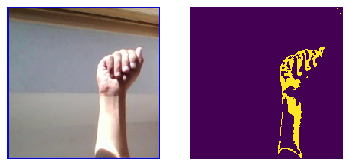

In [16]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(rgb);         ax[0].axis('off')
ax[1].imshow(thresholded); ax[1].axis('off')
plt.show()

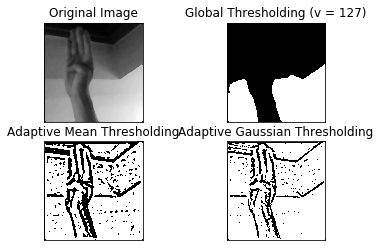

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('asl_alphabet_train\\B\\B2021.jpg',0)
img = cv2.medianBlur(img,5)

ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [18]:
import numpy as np
import cv2 as cv
im = cv.imread('asl_alphabet_train\\B\\B2021.jpg')
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

In [19]:
cv.drawContours(im2, contours, -1, (0,255,0), 3)

NameError: name 'im2' is not defined

In [12]:
cv.__version__

'4.1.1'

In [3]:
import cv2
import os

image_folder = 'asl_alphabet_train\\B'
video_name = 'B.avi'

images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
# sorting images in order
images = sorted(images, key = lambda x: int(x[1:-4]))
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 1, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [20]:
sorted(images, key = lambda x: int(x[1:-4]))

['B1.jpg',
 'B2.jpg',
 'B3.jpg',
 'B4.jpg',
 'B5.jpg',
 'B6.jpg',
 'B7.jpg',
 'B8.jpg',
 'B9.jpg',
 'B10.jpg',
 'B11.jpg',
 'B12.jpg',
 'B13.jpg',
 'B14.jpg',
 'B15.jpg',
 'B16.jpg',
 'B17.jpg',
 'B18.jpg',
 'B19.jpg',
 'B20.jpg',
 'B21.jpg',
 'B22.jpg',
 'B23.jpg',
 'B24.jpg',
 'B25.jpg',
 'B26.jpg',
 'B27.jpg',
 'B28.jpg',
 'B29.jpg',
 'B30.jpg',
 'B31.jpg',
 'B32.jpg',
 'B33.jpg',
 'B34.jpg',
 'B35.jpg',
 'B36.jpg',
 'B37.jpg',
 'B38.jpg',
 'B39.jpg',
 'B40.jpg',
 'B41.jpg',
 'B42.jpg',
 'B43.jpg',
 'B44.jpg',
 'B45.jpg',
 'B46.jpg',
 'B47.jpg',
 'B48.jpg',
 'B49.jpg',
 'B50.jpg',
 'B51.jpg',
 'B52.jpg',
 'B53.jpg',
 'B54.jpg',
 'B55.jpg',
 'B56.jpg',
 'B57.jpg',
 'B58.jpg',
 'B59.jpg',
 'B60.jpg',
 'B61.jpg',
 'B62.jpg',
 'B63.jpg',
 'B64.jpg',
 'B65.jpg',
 'B66.jpg',
 'B67.jpg',
 'B68.jpg',
 'B69.jpg',
 'B70.jpg',
 'B71.jpg',
 'B72.jpg',
 'B73.jpg',
 'B74.jpg',
 'B75.jpg',
 'B76.jpg',
 'B77.jpg',
 'B78.jpg',
 'B79.jpg',
 'B80.jpg',
 'B81.jpg',
 'B82.jpg',
 'B83.jpg',
 'B84.jpg',
 

## Moving object detection


In [31]:
# https://opencv-python-tutroals.readthedocs.io/en/stable/py_tutorials/py_video/py_bg_subtraction/py_bg_subtraction.html
import numpy as np
import cv2

cap = cv2.VideoCapture('B.avi')

fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()

while(1):
    ret, frame = cap.read()

    fgmask = fgbg.apply(frame)

    cv2.imshow('frame',fgmask)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.1.1) ..\modules\highgui\src\window.cpp:352: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [5]:
import numpy as np
import cv2

cap = cv2.VideoCapture('B.avi')

fgbg = cv2.createBackgroundSubtractorMOG2()

while(1):
    ret, frame = cap.read()

    fgmask = fgbg.apply(frame)

    cv2.imshow('frame',fgmask)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [7]:
import numpy as np
import cv2

cap = cv2.VideoCapture('B.avi')

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fgbg = cv2.bgsegm.createBackgroundSubtractorMOG()

while(1):
    ret, frame = cap.read()

    fgmask = fgbg.apply(frame)
    fgmask = cv2.morphologyEx(fgmask, cv2.MORPH_OPEN, kernel)

    cv2.imshow('frame',fgmask)
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break

cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 

In [8]:
from skimage import segmentation

In [9]:
import skimage
from skimage import data

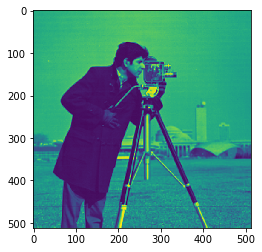

In [15]:
plt.imshow(data.camera())

In [24]:
img = cv2.imread('asl_alphabet_train\\A\\A1619.jpg')



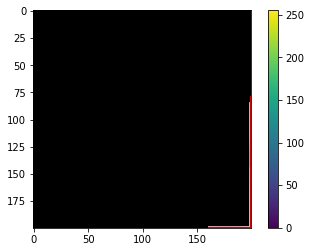

In [26]:
cv2.grabCut(img,mask,rect,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_RECT)
img = img*mask2[:,:,np.newaxis]

plt.imshow(img)
plt.colorbar()
plt.show()

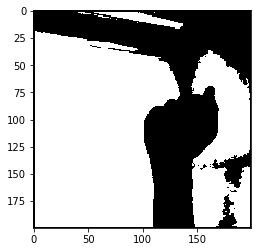

In [7]:
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

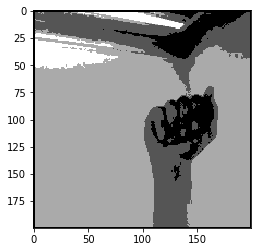

In [8]:
gray = rgb2gray(image)
gray_r = gray.reshape(gray.shape[0]*gray.shape[1])
for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 3
    elif gray_r[i] > 0.5:
        gray_r[i] = 2
    elif gray_r[i] > 0.25:
        gray_r[i] = 1
    else:
        gray_r[i] = 0
gray = gray_r.reshape(gray.shape[0],gray.shape[1])
plt.imshow(gray, cmap='gray')

(200, 200, 3)


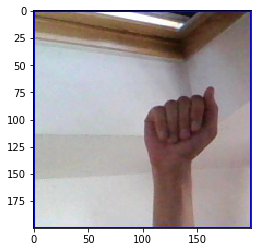

In [9]:
pic = plt.imread('asl_alphabet_train\\A\\A1619.jpg')/255  # dividing by 255 to bring the pixel values between 0 and 1
print(pic.shape)
plt.imshow(pic)

In [10]:
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape

(40000, 3)

In [12]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]

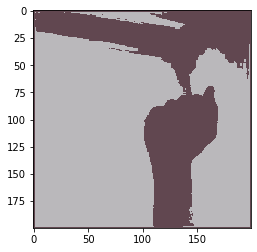

In [13]:
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)

ModuleNotFoundError: No module named 'nets'

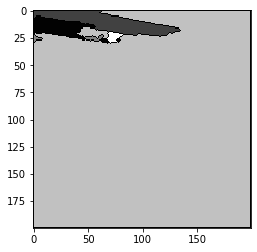

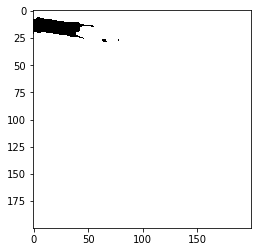

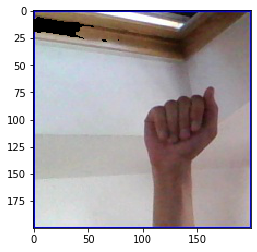

In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
img = cv2.imread("asl_alphabet_train\\A\\A1619.jpg", 3)

# Create a blank image of zeros (same dimension as img)
# It should be grayscale (1 color channel)
marker = np.zeros_like(img[:,:,0]).astype(np.int32)

# This step is manual. The goal is to find the points
# which create the result we want. I suggest using a
# tool to get the pixel coordinates.

# Dictate the background and set the markers to 1
marker[20][5] = 1
marker[20][37] = 1
marker[25][44] = 1
marker[20][27] = 1
marker[27][78] = 1
marker[27][66] = 1

# Dictate the area of interest
# I used different values for each part of the car (for visibility)
marker[25][70] = 255    # car body
marker[15][94] = 64     # rooftop
marker[10][54] = 64     # rear light
marker[17][58] = 64     # rear wing
marker[25][3] = 128    # front bumper

# rear bumper
marker[25][56] = 128
marker[24][61] = 128
marker[26][61] = 128
# front wheel
marker[25][89] = 192
marker[20][47] = 192

# rear wheel
marker[28][9] = 192
marker[27][91] = 192
marker[24][21] = 192

# Now we have set the markers, we use the watershed
# algorithm to generate a marked image
marked = cv2.watershed(img, marker)

# Plot this one. If it does what we want, proceed;
# otherwise edit your markers and repeat
plt.imshow(marked, cmap='gray')
plt.show()

# Make the background black, and what we want to keep white
marked[marked == 1] = 0
marked[marked > 1] = 255

# Use a kernel to dilate the image, to not lose any detail on the outline
# I used a kernel of 3x3 pixels
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(marked.astype(np.float32), kernel, iterations = 1)

# Plot again to check whether the dilation is according to our needs
# If not, repeat by using a smaller/bigger kernel, or more/less iterations
plt.imshow(dilation, cmap='gray')
plt.show()

# Now apply the mask we created on the initial image
final_img = cv2.bitwise_and(img, img, mask=dilation.astype(np.uint8))

# cv2.imread reads the image as BGR, but matplotlib uses RGB
# BGR to RGB so we can plot the image with accurate colors
b, g, r = cv2.split(final_img)
final_img = cv2.merge([r, g, b])

# Plot the final result
plt.imshow(final_img)
plt.show()

In [43]:
#!/usr/bin/python3
# 2018.01.20 20:58:12 CST
# 2018.01.20 21:24:29 CST
import cv2
import numpy as np

## (1) Read
img = cv2.imread("asl_alphabet_train\\A\\A1619.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

## (2) Threshold
th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)

## (3) Find the min-area contour
cnts = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]
cnts = sorted(cnts, key=cv2.contourArea)
for cnt in cnts:
    if cv2.contourArea(cnt) > 100:
        break

## (4) Create mask and do bitwise-op
mask = np.zeros(img.shape[:2],np.uint8)
cv2.drawContours(mask, [cnt],-1, 255, -1)
dst = cv2.bitwise_and(img, img, mask=mask)

## Save it
cv2.imwrite("dst.png", dst)

True

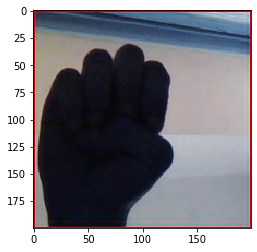

ValueError: Only images with 2 spatial dimensions are supported. If using with color/multichannel images, specify `multichannel=True`.

In [43]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure

image = cv2.imread('E160.jpg')
plt.imshow(image)
plt.show()
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = data.astronaut()

fd, hog_image = hog(image, orientations=100, pixels_per_cell=(30, 30),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 255))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [23]:
cv2.imread(f'{PATH}A/A1.jpg', cv2.IMREAD_GRAYSCALE).shape

(200, 200)

In [34]:
image.shape

(200, 200)